<a href="https://colab.research.google.com/github/jini-ninii/ML_labs/blob/main/lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas seaborn scikit-learn

# Домашнее задание 4

1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)
2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат
3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат
4. Сделать DBSSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат
5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

### **1. Преобразовать датасет (процессинг категориальных признаков, копия данных в df_not_processed, scale датасета)**

In [3]:
df_main = pd.read_csv('/content/Sleep_health_and_lifestyle_dataset.csv')
df = df_main.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [5]:
df = df.drop('Person ID', axis=1)

In [6]:
df['Sleep Disorder'].fillna('None', inplace=True)

df_not_processed = df.copy()

object_columns = df.select_dtypes(include=['object']).columns
for col in object_columns:
    df[col] = df[col].astype('category')

df_processed = pd.get_dummies(df, drop_first=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Gender                   374 non-null    category
 1   Age                      374 non-null    int64   
 2   Occupation               374 non-null    category
 3   Sleep Duration           374 non-null    float64 
 4   Quality of Sleep         374 non-null    int64   
 5   Physical Activity Level  374 non-null    int64   
 6   Stress Level             374 non-null    int64   
 7   BMI Category             374 non-null    category
 8   Blood Pressure           374 non-null    category
 9   Heart Rate               374 non-null    int64   
 10  Daily Steps              374 non-null    int64   
 11  Sleep Disorder           374 non-null    category
dtypes: category(5), float64(1), int64(6)
memory usage: 24.0 KB


/tmp/ipython-input-2657777635.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sleep Disorder'].fillna('None', inplace=True)


In [7]:
df_processed = pd.get_dummies(df, drop_first=True)

In [8]:
scaler = StandardScaler()
numeric_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns
df_processed[numeric_cols] = scaler.fit_transform(df_processed[numeric_cols])
df_scaled = df_processed

Эта часть кода выполняет предварительную обработку данных.

Сначала удаляется ненужный столбец Person ID. Затем все пропущенные значения в столбце Sleep Disorder заменяются на текстовое значение 'None', чтобы превратить их в отдельную категорию.

Все текстовые столбцы преобразуются в числовой формат с помощью метода One-Hot Encoding (get_dummies).

В конце ко всем числовым данным применяется StandardScaler. Он стандартизирует каждый столбец, чтобы признаки с большими значениями не оказывали большего влияния на результат, чем признаки с маленькими значениями.

### **2. Сделать k-means кластеризацию (записать cluster в df_not_processed, вывести статистику, графики. попробовать объяснить принцип кластеризации), оценить метриками, вывести результат**

Silhouette: 0.414
Davies-Bouldin Index: 1.076
Calinski-Harabasz: 159.480
cluster
2    173
1    100
0     69
3     32
Name: count, dtype: int64
               Age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
cluster                                                                         
0        55.275362        8.250725          9.000000                54.855072   
1        37.770000        6.340000          5.980000                40.150000   
2        38.115607        7.341040          7.653179                66.184971   
3        49.750000        6.065625          6.000000                90.000000   

         Stress Level  Heart Rate   Daily Steps  cluster  
cluster                                                   
0            3.028986   67.159420   6005.797101      0.0  
1            7.190000   73.820000   5507.000000      1.0  
2            4.797688   68.358382   7308.670520      2.0  
3            8.000000   75.000000  10000.000000      3.0  


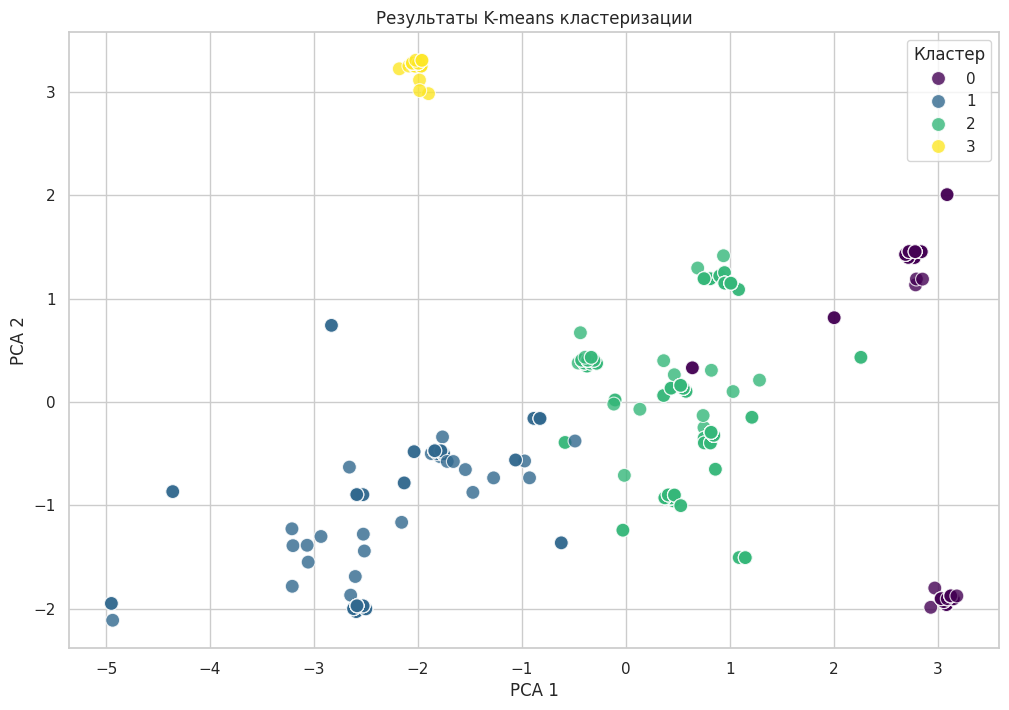

In [9]:
# Обучаем K-Means, k = 4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaled)

# Записываем результат кластеризации в df_not_processed
df_not_processed['cluster'] = clusters

# Метрики для оценки качества кластеризации
silhouette = silhouette_score(df_scaled, clusters)
dbi = davies_bouldin_score(df_scaled, clusters)
calinski = calinski_harabasz_score(df_scaled, clusters)
print(f"Silhouette: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")
print(f"Calinski-Harabasz: {calinski:.3f}")

# Средние значения по каждому кластеру
numeric_cols = df_not_processed.select_dtypes(include=['number']).columns
print(df_not_processed['cluster'].value_counts())
print(df_not_processed.groupby('cluster')[numeric_cols].mean())

# Выводим график
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=clusters, palette='viridis', s=100, alpha=0.8)
plt.title('Результаты K-means кластеризации')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Кластер')
plt.grid(True)
plt.show()

* Кластер 0: Это самая старшая группа (средний возраст 55 лет) с отличным качеством и продолжительностью сна, но низкой физической активностью.

* Кластер 1: Группа молодых людей (37 лет) с самым плохим качеством сна и самым высоким уровнем стресса.

* Кластер 2: Самая большая и "усредненная" группа, чьи показатели близки к средним по всему датасету.

* Кластер 3: Уникальная группа людей среднего возраста (49 лет) с максимальным уровнем стресса, но при этом самой высокой физической активностью.

Кластер 2 является самым большим и распространённым (173 человека), а кластер 3 - самым маленьким и, возможно, самым специфичным (всего 32 человека). Это помогает понять, какие группы людей являются более типичными, а какие - более редкими.

Silhouette - метрика оценивает, насколько объект похож на свой собственный кластер по сравнению с другими. Наш результат говорит о том, что в среднем точки в датасете находятся ближе к своим кластерам, чем к соседним. Кластеры имеют четкую структуру и являются достаточно обособленными, хотя и не идеально разделенными.

Calinski-Harabasz - оценивает качество кластеризации, сравнивая, насколько кластеры "разбросаны" между собой, с тем, насколько они "компактны" внутри себя. Более высокое значение означает, что кластеры более плотные и лучше разделены. При другом значении k это значение ниже, значит k = 4 - наилучший выбор для данных.

Касаемо графика - кластеры 3 желтый и основная масса кластера 0 фиолетовый выглядят очень плотными и изолированными. Это говорит о том, что люди в этих группах обладают набором очень специфических и схожих между собой признаков, которые четко отделяют их от всех остальных. В то же время, кластеры 1 синий и 2 зеленый более «размыты» и расположены ближе друг к другу, что указывает на большее разнообразие внутри этих групп и на частичное пересечение их характеристик.

### **3. Подобрать оптимальное число кластеров с помощью "метод локтя", вывести статистику, графики, метрики, объяснить результат**

k=2:  Inertia = 2535.31,  Silhouette = 0.314
k=3:  Inertia = 2055.66,  Silhouette = 0.371
k=4:  Inertia = 1549.96,  Silhouette = 0.414
k=5:  Inertia = 1307.75,  Silhouette = 0.430
k=6:  Inertia = 1083.17,  Silhouette = 0.486
k=7:  Inertia = 918.28,  Silhouette = 0.523
k=8:  Inertia = 787.99,  Silhouette = 0.538
k=9:  Inertia = 665.90,  Silhouette = 0.565
k=10:  Inertia = 563.90,  Silhouette = 0.606


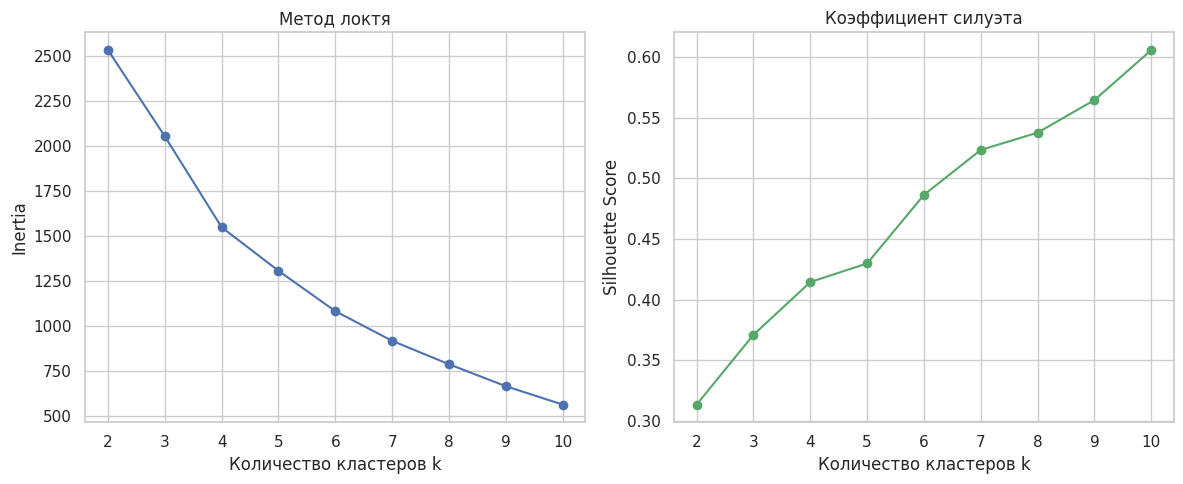

In [10]:
inertias = []
silhouettes = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertias.append(kmeans.inertia_)  # Вутренняя метрика K-Means
    silhouettes.append(silhouette_score(df_scaled, kmeans.labels_))  # Внешняя метрика

for k, inertia, silhouette in zip(K, inertias, silhouettes):
    print(f"k={k}:  Inertia = {inertia:.2f},  Silhouette = {silhouette:.3f}")

# Визуализация "метода локтя"
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K, inertias, 'bo-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia')
plt.title('Метод локтя')

plt.subplot(1,2,2)
plt.plot(K, silhouettes, 'go-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Silhouette Score')
plt.title('Коэффициент силуэта')
plt.tight_layout()
plt.show()

Оптимальное число кластеров — четыре.

На левом графике в точке k = 4 мы видим самый резкий "изгиб локтя". Дальше линия становится почти прямой, а значит, добавлять новые кластеры уже бессмысленно.

Правый график показывает, что чем на большее количество мелких групп мы делим данные, тем более "чистыми" и обособленными эти группы становятся. Если продолжать, то в итоге у нас будет столько же кластеров, сколько и людей, и метрика будет идеальной, но пользы от этого - ноль. Поэтому мы ищем баланс, который нам и показывает "локоть" на левом графике.

### **4. Сделать DBSSCAN кластеризацию, подобрать оптимальные параметры, посчитать метрики, вывести статистику, объяснить результат**

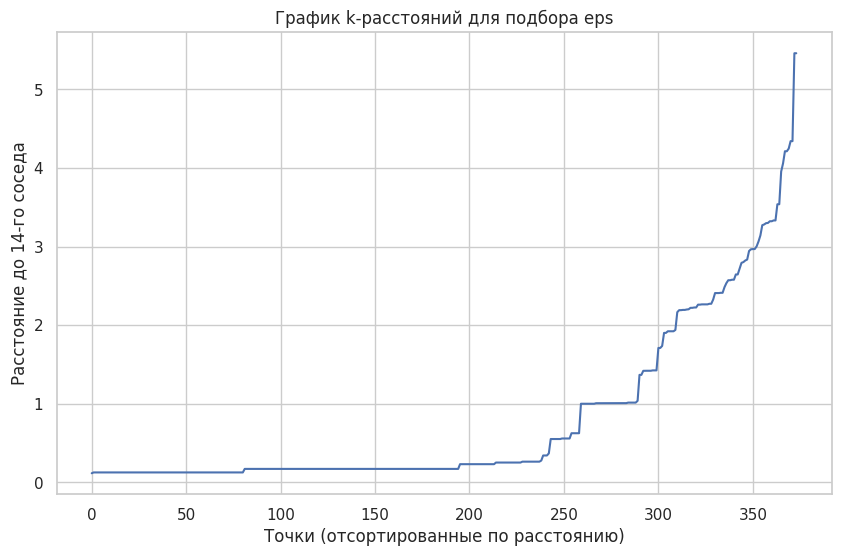

In [11]:
# Возьмем более консервативное значение, например 15.
min_samples = 15
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(df_scaled)
distances, indices = neighbors_fit.kneighbors(df_scaled)

# Сортируем расстояния и строим график
sorted_distances = np.sort(distances[:, min_samples-1])

plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.title('График k-расстояний для подбора eps')
plt.xlabel('Точки (отсортированные по расстоянию)')
plt.ylabel(f'Расстояние до {min_samples-1}-го соседа')
plt.grid(True)
plt.show()

На графике ищем точку "колена", где кривая начинает резко расти. Визуально, это значение находится примерно в районе 2,2.

In [12]:
eps = 2.2

dbscan_cluster
 0    132
-1     55
 2     38
 6     33
 5     32
 4     32
 3     27
 1     25
Name: count, dtype: int64
                      Age  Sleep Duration  Quality of Sleep  \
dbscan_cluster                                                
-1              36.654545        6.789091          6.563636   
 0              36.772727        7.494697          7.757576   
 1              32.320000        6.060000          6.000000   
 2              44.868421        6.428947          6.157895   
 3              44.370370        6.596296          7.000000   
 4              49.750000        6.065625          6.000000   
 5              52.781250        8.425000          9.000000   
 6              58.030303        8.093939          9.000000   

                Physical Activity Level  Stress Level  Heart Rate  \
dbscan_cluster                                                      
-1                            50.363636      6.018182   74.654545   
 0                            71.212121  

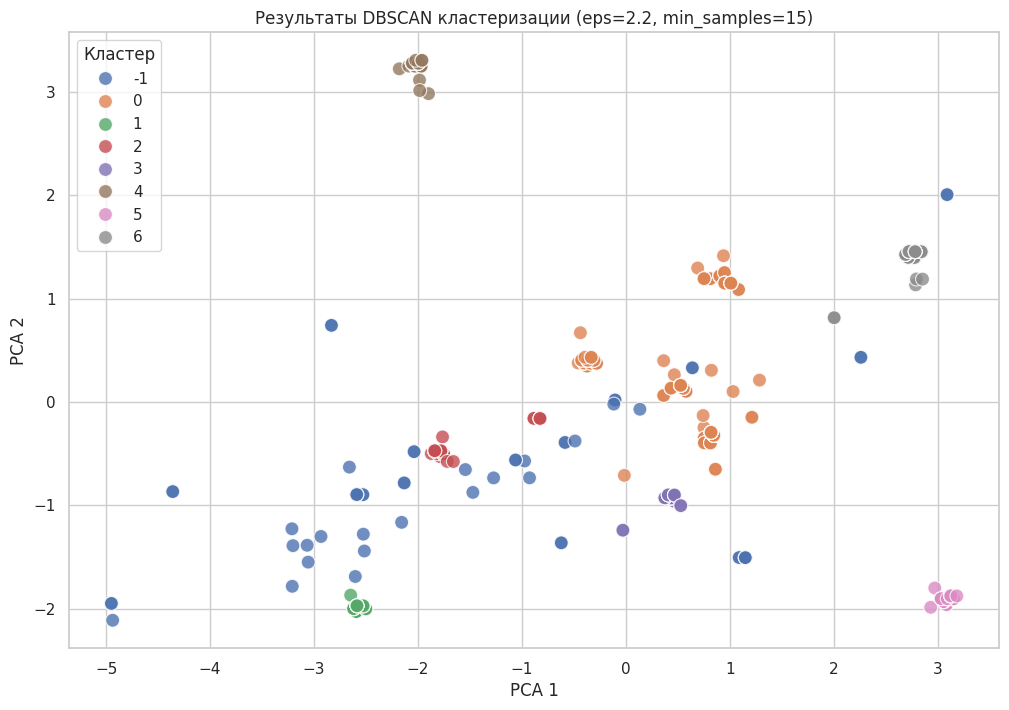

In [13]:
# Инициализируем и обучаем модель
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(df_scaled)
df_not_processed['dbscan_cluster'] = clusters

# Средние значения по каждому кластеру
numeric_cols = df_not_processed.select_dtypes(include=['number']).columns
print(df_not_processed['dbscan_cluster'].value_counts())
print(df_not_processed.groupby('dbscan_cluster')[numeric_cols].mean())

n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

if n_clusters > 1:
    mask = clusters != -1
    silhouette = silhouette_score(df_scaled[mask], clusters[mask])
    dbi = davies_bouldin_score(df_scaled[mask], clusters[mask])
    calinski = calinski_harabasz_score(df_scaled[mask], clusters[mask])
    print(f"Silhouette Score (без учета шума): {silhouette:.3f}")
    print(f"Davies-Bouldin Index: {dbi:.3f}")
    print(f"Calinski-Harabasz: {calinski:.3f}")
else:
    print("Silhouette Score не может быть рассчитан, так как найден 1 кластер или меньше.")

# Используем тот же PCA, что и для K-means, для сопоставимости
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=clusters, palette='deep', s=100, alpha=0.8)
plt.title(f'Результаты DBSCAN кластеризации (eps={eps}, min_samples={min_samples})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Кластер')
plt.grid(True)
plt.show()

DBSCAN сработал совершенно иначе, чем K-Means, и показал другую структуру данных. Вместо того чтобы делить всех на большие группы, он выделил 7 небольших, но очень плотных и специфических кластеров, а 55 человек (15% от всех данных) посчитал "шумом" - то есть, людьми, чьи характеристики не позволяют отнести их ни к одной из плотных групп.

Самый большой кластер 0 (132 человека) представляет собой "усредненное ядро" датасета. А остальные маленькие кластеры - это очень узкие "ниши".

Очень высокий Silhouette Score (0.670) подтверждает, что найденные кластеры (без учета шума) плотные и четко отделены друг от друга.

### **5. Ответить на вопрос - какой из методов кластеризации больше подходит для вашего датасета**

По моему мнению, лучше подходит DBSCAN.

Главное преимущество DBSCAN - его способность находить и отделять "шум" (точки, которые не принадлежат ни к одному плотному скоплению). Вместо того чтобы насильно включать их в ближайшую группу (как это сделал K-means), DBSCAN честно показывает, что они не являются частью какой-либо явной структуры, что дает более реалистичную картину.

